# OSM pre-processing 

## Packages and dirs

In [2]:
import os
import geopandas as gpd
import numpy as np

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

import matplotlib.pyplot as plt

# Set the working directory
wd = 'D:/data/OSM/United States of America/norcal-latest-free.shp/'
os.chdir(wd)


## Input data

### AOI

In [3]:
# Load the shapefile
# Load the San Francisco boundary (e.g., from a shapefile or GeoJSON)

dir_shp = 'D:/natcap/invest-mental-health/data'
aoi_path = os.path.join(dir_shp, 'cb_2019_us_county_500k_06075_clip.shp')
aoi = gpd.read_file(aoi_path)


### Park - OSM data

In [4]:
# Step 1: Read in the shapefile
osm_path = 'gis_osm_landuse_a_free_1.shp'
gdf = gpd.read_file(osm_path)


In [5]:
print(gdf.columns)
# print(gdf.head)
print(gdf['fclass'].unique())
print(gdf['name'].unique())


Index(['osm_id', 'code', 'fclass', 'name', 'geometry'], dtype='object')
['park' 'nature_reserve' 'forest' 'industrial' 'cemetery' 'retail'
 'recreation_ground' 'commercial' 'grass' 'allotments' 'residential'
 'farmland' 'scrub' 'quarry' 'farmyard' 'orchard' 'military' 'meadow'
 'vineyard' 'heath']
['Klein Park' 'Aramburu Island' 'Buena Vista Park' ...
 'Sausalito Shipyard and Marine' 'Merced Station'
 'Buena Vista Midtown Senior Apartments']


### NDVI and TCC rasters

In [6]:
# Step 1: Load the NDVI raster
ndvi_raster_path = 'D:/natcap/invest-mental-health/data/ndvi_s2_075_2019_10m_reprojected.tif'

tcc_path = 'E:/_data/LULC/NLCD_USA/NLCD_TCC/nlcd_tcc_conus_2021_v2021-4_clipped_reprojected_aligned.tif'


## Processing 

### Classify OSM land use

In [7]:

# Define terms and their corresponding categories
park_terms = ['park']
agriculture_terms = ['allotments', 'farmland', 'farmyard']


# Function to normalize and classify land use
import unicodedata

def normalize_text(text):
    # Normalize the text to remove accents and special characters
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()



def classify_lulc(row):
    # Normalize and check for 'Park' related terms
    fclass_norm = normalize_text(row['fclass']) if row['fclass'] is not None else ''
    name_norm = normalize_text(row['name']) if row['name'] is not None else ''
    
    if any(term in fclass_norm for term in park_terms) or any(term in name_norm for term in park_terms):
        return 'park'
    
    # Normalize and check for 'Agriculture' related terms
    elif any(term in fclass_norm for term in agriculture_terms) or any(term in name_norm for term in agriculture_terms):
        return 'agriculture'
    
    # If no conditions are met, return the value in 'fclass'
    else:
        return row['fclass'] if row['fclass'] is not None else ''

# Apply the function to create the 'lulc' column
gdf['lulc'] = gdf.apply(classify_lulc, axis=1)


print(gdf[['fclass', 'name', 'lulc']].head(10))


           fclass                             name            lulc
0            park                       Klein Park            park
1  nature_reserve                  Aramburu Island  nature_reserve
2            park                 Buena Vista Park            park
3          forest                 Buena Vista Park            park
4            park        Babbs Creek Park Preserve            park
5            park                César Chávez Park            park
6  nature_reserve  Point Isabel Regional Shoreline  nature_reserve
7      industrial                             None      industrial
8          forest                             None          forest
9          forest                             None          forest


### Save reclassified OSM

In [8]:

# Step 3 (Optional): Save the updated shapefile
osm_reclassified_path = osm_path.replace('1.shp', 'natcap.shp')
gdf.to_file(osm_reclassified_path, encoding='utf-8')

print("New column added and shapefile updated successfully.")


New column added and shapefile updated successfully.


### Filter OSM Park layer only, and save

In [9]:
# Filter the GeoDataFrame to include only rows where 'lulc' is 'Park'
parks_gdf = gdf[gdf['lulc'] == 'park']

# Print the first few rows to verify the filtered data
print(parks_gdf[['fclass', 'name', 'lulc']].head(10))

# Save the filtered GeoDataFrame to a new shapefile
osm_park_path = osm_path.replace('1.shp', 'natcap_park.shp')
# parks_gdf.to_file(osm_park_path, encoding='utf-8')


    fclass                       name  lulc
0     park                 Klein Park  park
2     park           Buena Vista Park  park
3   forest           Buena Vista Park  park
4     park  Babbs Creek Park Preserve  park
5     park          César Chávez Park  park
13    park              Campbell Park  park
14    park                Sylvan Park  park
15    park               De Anza Park  park
16    park              Market Square  park
17    park                  Yuba Park  park


### Park map

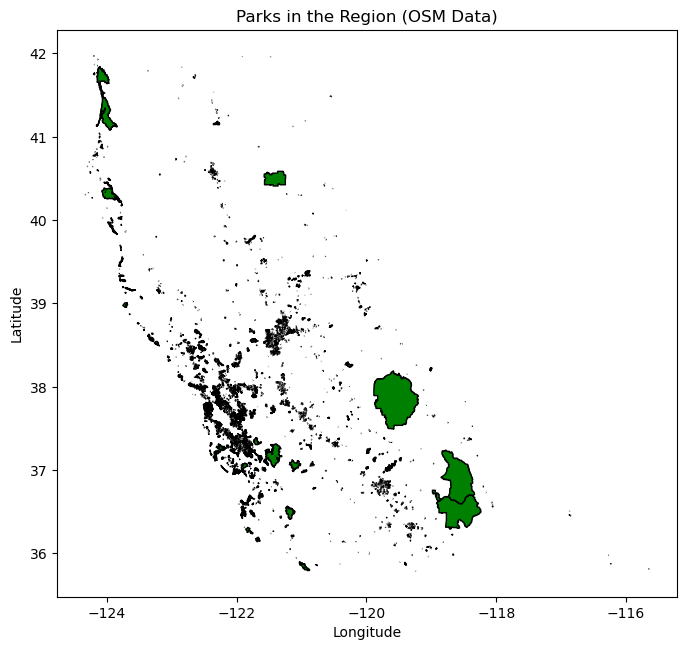

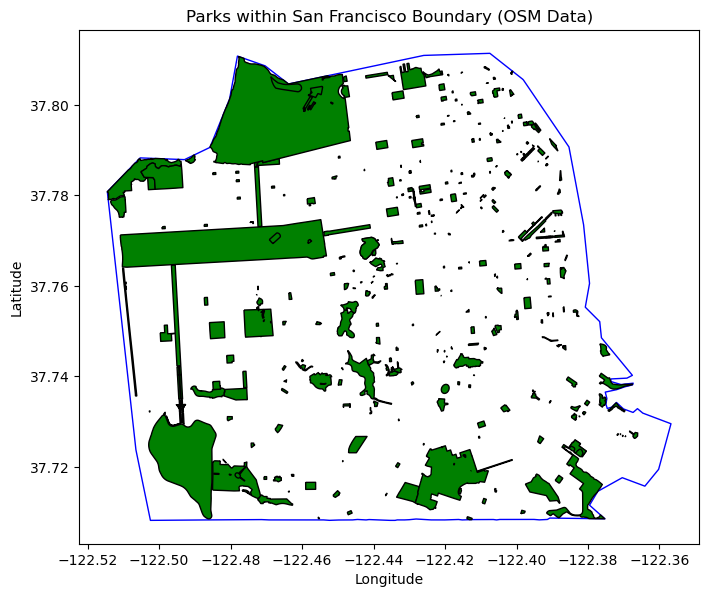

Clipped parks shapefile saved to 
gis_osm_landuse_a_free_natcap_park_clipped.shp


In [10]:


# Plot all the parks
fig, ax = plt.subplots(figsize=(8, 8))
parks_gdf.plot(ax=ax, color='green', edgecolor='black')
# Customize the plot
ax.set_title('Parks in the Region (OSM Data)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



## clip to AOI and plot 
# Step 2: Ensure both GeoDataFrames are in the same CRS
if parks_gdf.crs != aoi.crs:
    parks_gdf = parks_gdf.to_crs(aoi.crs)

# Step 3: Clip the parks by the San Francisco boundary
parks_clipped = gpd.clip(parks_gdf, aoi)
aoi_park = parks_clipped
aoi_crs = parks_gdf.crs

# Step 4: Visualize the clipped parks
fig, ax = plt.subplots(figsize=(8, 8))
aoi.plot(ax=ax, edgecolor='blue', color='none')  # Plot SF boundary
parks_clipped.plot(ax=ax, color='green', edgecolor='black')  # Plot clipped parks

# Customize the plot
ax.set_title('Parks within San Francisco Boundary (OSM Data)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

# Step 5 (Optional): Save the clipped parks to a new shapefile
osm_park_clipped_path = osm_path.replace('1.shp', 'natcap_park_clipped.shp')
parks_clipped.to_file(osm_park_clipped_path)

print(f"Clipped parks shapefile saved to \n{osm_park_clipped_path}")


### NDVI clip and viz

Reprojecting AOI from EPSG:4269 to PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Reprojecting city boundary from EPSG:4269 to PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitu

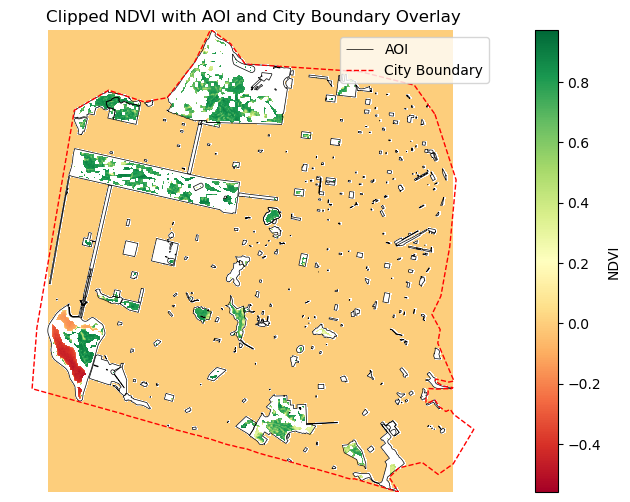

In [11]:
with rasterio.open(ndvi_raster_path) as ndvi_src:
    ndvi = ndvi_src.read(1)
    ndvi_crs = ndvi_src.crs
    ndvi_meta = ndvi_src.meta


if aoi_park.crs != ndvi_crs:
    print(f"Reprojecting AOI from {aoi_park.crs} to {ndvi_crs}")
    aoi_park = aoi_park.to_crs(ndvi_crs)

aoi_region = aoi
if aoi_region.crs != ndvi_crs:
    print(f"Reprojecting city boundary from {aoi_region.crs} to {ndvi_crs}")
    aoi_region = aoi_region.to_crs(ndvi_crs)


# Step 1: Calculate the area of each park
aoi_park['area_sqm'] = aoi_park.geometry.area  # Area will be in square meters if CRS is in meters
# Convert the area to other units (e.g., square kilometers)
aoi_park['area_sqkm'] = aoi_park['area_sqm'] / 1e6  # Convert square meters to square kilometers


# Step 3: Clip the NDVI raster using the reprojected AOI
aoi_geometry = [aoi_park.geometry.unary_union]

with rasterio.open(ndvi_raster_path) as src:
    ndvi_clipped, ndvi_clipped_transform = mask(src, aoi_geometry, crop=True)
    ndvi_clipped_meta = src.meta.copy()
    ndvi_clipped_meta.update({
        "driver": "GTiff",
        "height": ndvi_clipped.shape[1],
        "width": ndvi_clipped.shape[2],
        "transform": ndvi_clipped_transform
    })



# Step 2: Set NDVI values less than 0 to NaN
# ndvi_clipped[ndvi_clipped < 0] = np.nan

# # Step 4: Save the clipped NDVI raster
# ndvi_clipped_path = ndvi_raster_path.replace('.tif', '_clipped.tif'); print(ndvi_clipped_path)
# with rasterio.open(ndvi_clipped_path, 'w', **ndvi_clipped_meta) as dest:
#     dest.write(ndvi_clipped, 1)


# Step 6: Visualize the clipped NDVI with AOI and city boundary overlay
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(ndvi_clipped[0], cmap='RdYlGn', extent=[
    ndvi_clipped_transform[2],  # x_min
    ndvi_clipped_transform[2] + ndvi_clipped_transform[0] * ndvi_clipped.shape[2],  # x_max
    ndvi_clipped_transform[5] + ndvi_clipped_transform[4] * ndvi_clipped.shape[1],  # y_min
    ndvi_clipped_transform[5]  # y_max
])
plt.colorbar(label='NDVI')
aoi_park.boundary.plot(ax=ax, edgecolor='black', linewidth=.5, label='AOI')
aoi_region.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Customize the plot
ax.set_title('Clipped NDVI with AOI and City Boundary Overlay')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')
plt.legend()
plt.show()


#### Park with average NDVI

c:\ProgramData\Anaconda3\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


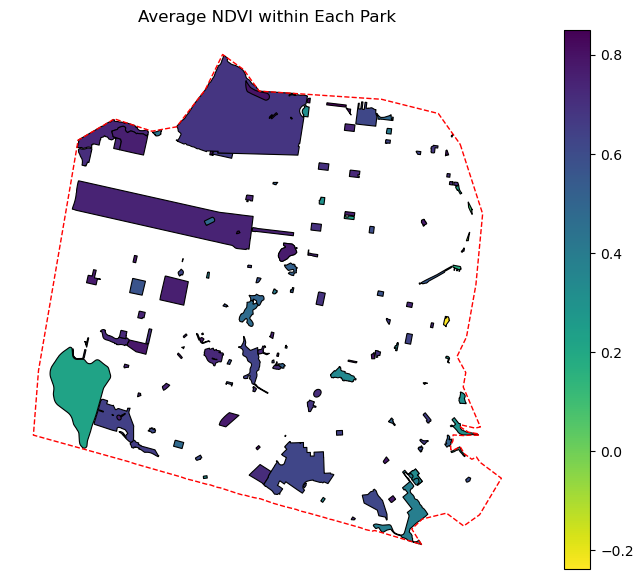

In [12]:
from rasterstats import zonal_stats

# print(ndvi_meta['nodata'])
# print(ndvi_src.nodata)

# Step 4: Calculate the average NDVI for each park using zonal statistics
stats = zonal_stats(aoi_park, ndvi_raster_path, stats=['mean'], nodata=ndvi_meta['nodata'])

# Add the average NDVI as a new column in the parks GeoDataFrame
aoi_park['avg_ndvi'] = [stat['mean'] for stat in stats]


# Step 5: Plot the parks color-coded by their average NDVI
fig, ax = plt.subplots(figsize=(10, 7))
aoi_park.plot(column='avg_ndvi', cmap='viridis_r', linewidth=0.8, ax=ax, edgecolor='black', legend=True)
aoi_region.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')
ax.set_title('Average NDVI within Each Park')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')

plt.show()

### TCC clip and viz

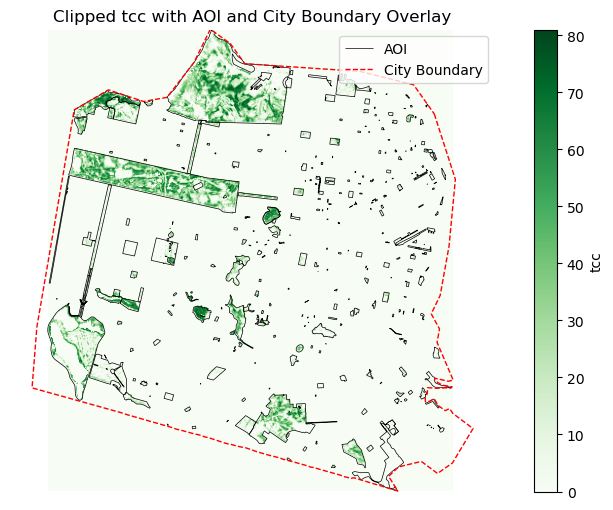

In [13]:
with rasterio.open(tcc_path) as tcc_src:
    tcc = tcc_src.read(1)
    tcc_crs = tcc_src.crs
    tcc_meta = tcc_src.meta


with rasterio.open(tcc_path) as src:
    tcc_clipped, tcc_clipped_transform = mask(src, aoi_geometry, crop=True)
    tcc_clipped_meta = src.meta.copy()
    tcc_clipped_meta.update({
        "driver": "GTiff",
        "height": tcc_clipped.shape[1],
        "width": tcc_clipped.shape[2],
        "transform": tcc_clipped_transform
    })



# Step 6: Visualize the clipped tcc with AOI and city boundary overlay
fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(tcc_clipped[0], cmap='Greens', extent=[
    tcc_clipped_transform[2],  # x_min
    tcc_clipped_transform[2] + tcc_clipped_transform[0] * tcc_clipped.shape[2],  # x_max
    tcc_clipped_transform[5] + tcc_clipped_transform[4] * tcc_clipped.shape[1],  # y_min
    tcc_clipped_transform[5]  # y_max
])
plt.colorbar(label='tcc')
aoi_park.boundary.plot(ax=ax, edgecolor='black', linewidth=.5, label='AOI')
aoi_region.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Customize the plot
ax.set_title('Clipped tcc with AOI and City Boundary Overlay')

ax.axis('off')
# ax.set_xticks([])  # Remove x-axis ticks
# ax.set_yticks([])  # Remove y-axis ticks
# ax.set_xticklabels([])  # Remove x-axis labels
# ax.set_yticklabels([])  # Remove y-axis labels
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

plt.legend()
plt.show()

#### Average TCC per park

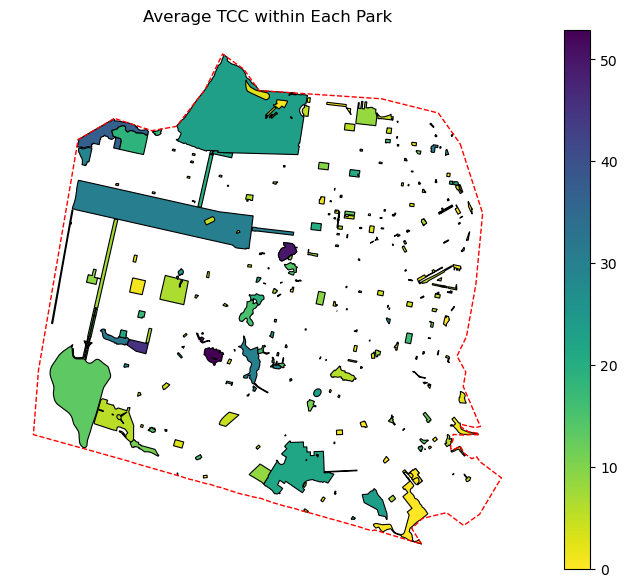

In [14]:
# Step 4: Calculate the average tcc for each park using zonal statistics
stats      = zonal_stats(aoi_park, tcc_path, stats=['mean'], nodata=tcc_meta['nodata'])
# ndvi_stats = zonal_stats(aoi_park, ndvi_raster_path, stats=['mean'], nodata=None)
# tree_stats = zonal_stats(aoi_park, tcc_path, stats=['mean'], nodata=None)

# Add the average tcc as a new column in the parks GeoDataFrame
aoi_park['avg_tcc'] = [stat['mean'] for stat in stats]


# Step 5: Plot the parks color-coded by their average tcc
fig, ax = plt.subplots(figsize=(10, 7))
aoi_park.plot(column='avg_tcc', cmap='viridis_r', linewidth=0.8, ax=ax, edgecolor='black', legend=True)
aoi_region.boundary.plot(ax=ax, edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')
ax.set_title('Average TCC within Each Park')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('off')

plt.show()

## Results

### Plot NDVI and TCC side by side 

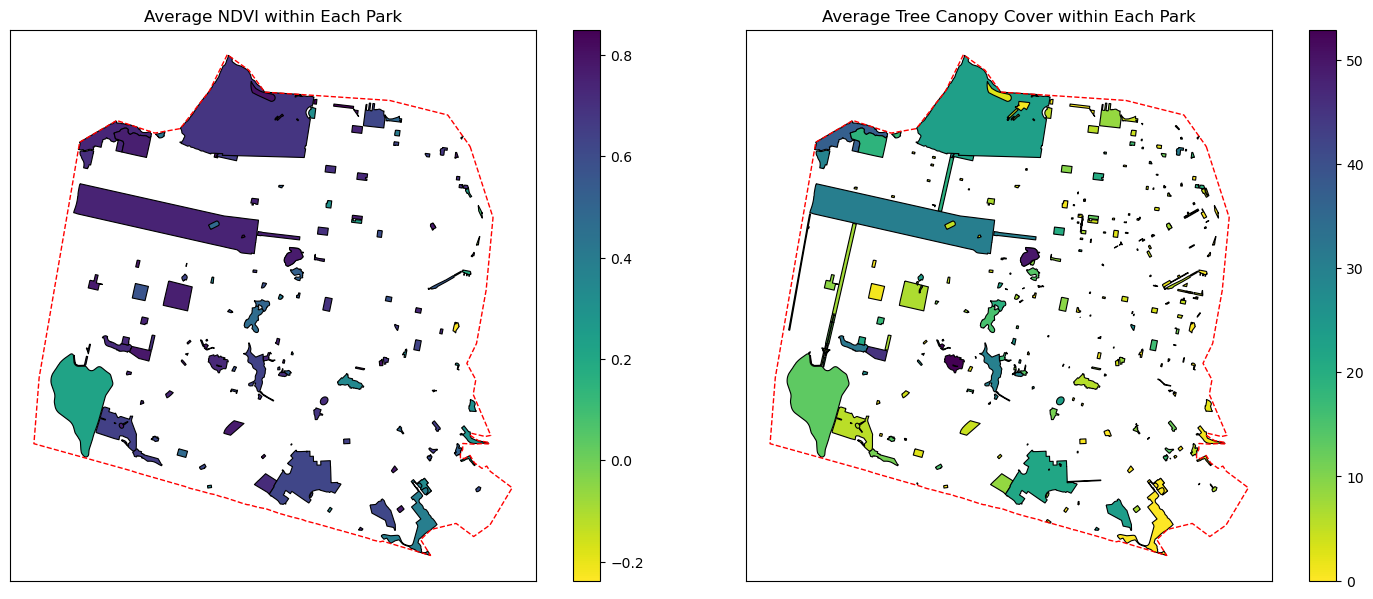

In [15]:
# Step 6: Plot the parks color-coded by their average NDVI and Tree Canopy Cover side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Average NDVI
aoi_park.plot(column='avg_ndvi', cmap='viridis_r', linewidth=0.8, ax=ax[0], edgecolor='black', legend=True)
ax[0].set_title('Average NDVI within Each Park')
# ax[0].set_xlabel('Longitude')
# ax[0].set_ylabel('Latitude')
ax[0].set_xticks([])  # Remove x-axis ticks
ax[0].set_yticks([])  # Remove y-axis ticks
ax[0].set_xticklabels([])  # Remove x-axis labels
ax[0].set_yticklabels([])  # Remove y-axis labels
aoi_region.boundary.plot(ax=ax[0], edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

# Plot 2: Average Tree Canopy Cover
aoi_park.plot(column='avg_tcc', cmap='viridis_r', linewidth=0.8, ax=ax[1], edgecolor='black', legend=True)
ax[1].set_title('Average Tree Canopy Cover within Each Park')
# ax[1].set_xlabel('Longitude')
# ax[1].set_ylabel('Latitude')
ax[1].set_xticks([])  # Remove x-axis ticks
ax[1].set_yticks([])  # Remove y-axis ticks
ax[1].set_xticklabels([])  # Remove x-axis labels
ax[1].set_yticklabels([])  # Remove y-axis labels
aoi_region.boundary.plot(ax=ax[1], edgecolor='red', linewidth=1, linestyle='--', label='City Boundary')

plt.tight_layout()
plt.show()

### NDVI vs TCC correlation? 

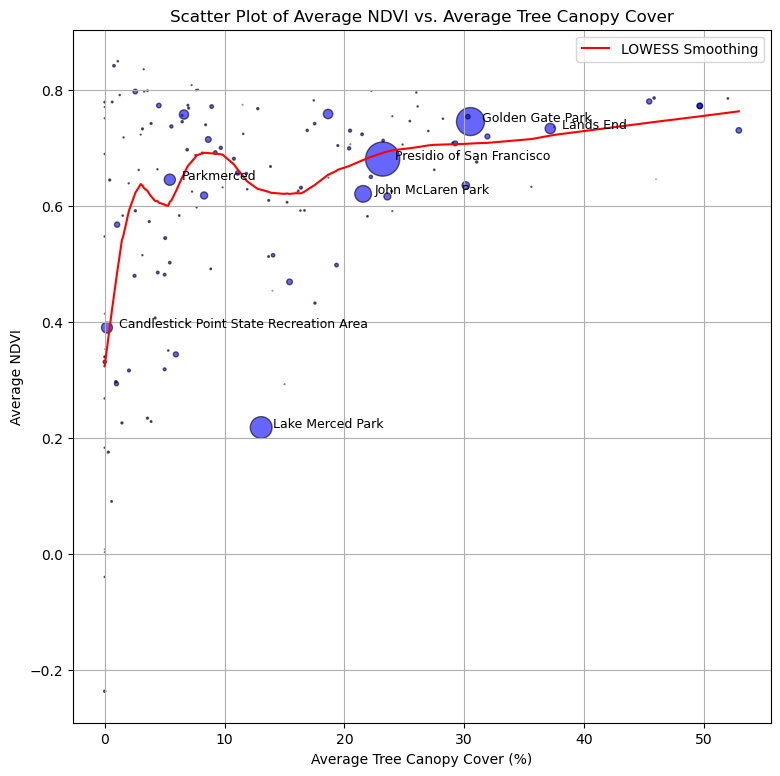

In [24]:
import statsmodels.api as sm


# Assuming parks_gdf has been created and contains 'avg_ndvi' and 'avg_tcc' columns
# Drop rows where either 'avg_ndvi' or 'avg_tree_canopy' is NaN
valid_data = aoi_park[['avg_ndvi', 'avg_tcc', 'area_sqm']].dropna()
# Extract the average NDVI and Tree Canopy Cover values
avg_ndvi = valid_data['avg_ndvi']
avg_tree_canopy = valid_data['avg_tcc']
park_area = valid_data['area_sqm']



# Adjust the scaling factor as needed
point_size = park_area / 1e4 
# Identify the top n largest parks
top_n_parks = aoi_park.nlargest(7, 'area_sqm')

# Step 2: Create the scatter plot
plt.figure(figsize=(9, 9))
plt.scatter(avg_tree_canopy, avg_ndvi, s=point_size, c='blue', edgecolor='black', alpha=0.6)
plt.title('Scatter Plot of Average NDVI vs. Average Tree Canopy Cover')
plt.xlabel('Average Tree Canopy Cover (%)')
plt.ylabel('Average NDVI')
plt.grid(True)

# Step 5: Add labels for the top n largest parks
for i, row in top_n_parks.iterrows():
    plt.text(row['avg_tcc']+1, row['avg_ndvi'], row['name'], fontsize=9, ha='left', color='black')

# Step 3: Apply LOWESS smoothing
lowess = sm.nonparametric.lowess(avg_ndvi, avg_tree_canopy, frac=0.25)  # Adjust frac for smoothing
x_smooth = lowess[:, 0]
y_smooth = lowess[:, 1]

# Step 4: Plot the LOWESS smooth line
plt.plot(x_smooth, y_smooth, 'r-', label='LOWESS Smoothing')
plt.legend()

plt.show()
